In [5]:


# 加载数据
data = pd.read_csv('C:/Users/starfish/Desktop/5507/cleaned_reuters_data_8.csv')

# 检查数据框的形状
print("Data shape:", data.shape)

# 打印前几行
print(data.head())

Data shape: (617, 6)
                                                name        time  \
0  US reopens asylum access for victims of domest...  2021-06-16   
1  Thousands call new Chinese domestic violence h...  2022-09-01   
2  USCs Bru McCoy wont face domestic violence cha...  2021-08-26   
3  Colts TE Drew Ogletree facing domestic violenc...  2023-12-30   
4  Jon Jones accepts plea domestic violence charg...  2021-12-16   

                                             content  \
0  WASHINGTON June 16 Reuters The US attorney gen...   
1  BEIJING Sept 1 Reuters Thousands of Chinese wo...   
2  20210826 023510 GMT0000 University of Southern...   
3  December 30 Indianapolis Colts tight end Drew ...   
4  20211216 174551 GMT0000 UFC fighter Jon Jones ...   

                                   location      source  \
0                                   Unknown  Ted Hesson   
1                                   Unknown     Reuters   
2                                   Unknown     Reuters 

In [6]:
# 将时间列转换为 datetime 类型
data['time'] = pd.to_datetime(data['time'], errors='coerce')
# 检查转换结果
print(data['time'].head())
# 删除时间转换失败的行
data.dropna(subset=['time'], inplace=True)

0   2021-06-16
1   2022-09-01
2   2021-08-26
3   2023-12-30
4   2021-12-16
Name: time, dtype: datetime64[ns]


C:\Users\starfish\AppData\Local\Temp\ipykernel_25364\108663877.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend_data = data.resample('M', on='time').size()


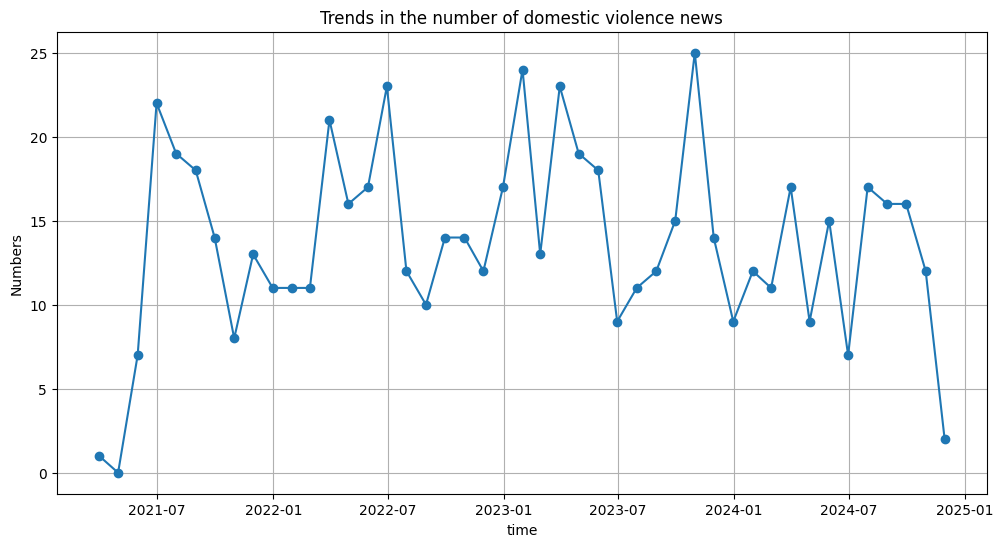

In [7]:
import matplotlib.pyplot as plt

# 按时间统计家暴新闻数量
trend_data = data.resample('M', on='time').size()
# 绘制趋势图
plt.figure(figsize=(12, 6))
plt.plot(trend_data.index, trend_data.values, marker='o')
plt.title('Trends in the number of domestic violence news')
plt.xlabel('time')
plt.ylabel('Numbers')
plt.grid()
plt.show()


In [10]:
import pandas as pd
import re

# 加载新闻数据
data = pd.read_csv('C:/Users/starfish/Desktop/5507/cleaned_reuters_data_8.csv', encoding='latin1')

# 按 Location 列统计每个地区的新闻数量
location_counts = data['location'].value_counts().reset_index()
location_counts.columns = ['location', 'incident_count']

# 加载城市坐标数据
cities_data = pd.read_csv('C:/Users/starfish/Desktop/5507/worldcities.csv/worldcities.csv', encoding='latin1')

# 使用实际的列名
cities_data = cities_data[['city', 'city_ascii', 'lng', 'lat']]  # 选择需要的列

# 提取城市名称并标准化
def extract_city(location):
    match = re.match(r'^(.*?),', location)
    if match:
        return match.group(1).strip().lower()  # 返回小写城市名称
    return location.strip().lower()  # 如果没有匹配，返回原始字符串的小写

location_counts['city'] = location_counts['location'].apply(extract_city)

# 将 cities_data 中的 city_ascii 列也转为小写
cities_data['city_ascii'] = cities_data['city_ascii'].str.lower()

# 合并数据框，使用合适的列名
final_data = pd.merge(location_counts, cities_data, left_on='city', right_on='city_ascii', how='left')

# 保存最终结果为 CSV
final_data.to_csv('C:/Users/starfish/Desktop/5507/locations_with_coordinates.csv', index=False)

print("合并完成并已保存为 'locations_with_coordinates.csv'")

合并完成并已保存为 'locations_with_coordinates.csv'


In [11]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# 读取数据
data = pd.read_csv('C:/Users/starfish/Desktop/5507/locations_with_coordinates.csv')

# 检查缺失值
print(data.isnull().sum())

# 清理缺失值，去除包含 NaN 的行
data = data.dropna(subset=['lat', 'lng'])

# 提取经纬度
heat_data = [[row['lat'], row['lng']] for index, row in data.iterrows()]

# 创建地图
m = folium.Map(location=[0, 0], zoom_start=2)  # 中心位置和缩放级别

# 添加热力图
HeatMap(heat_data).add_to(m)

# 显示地图
m

location           0
incident_count     0
city_x             0
city_y            36
city_ascii        36
lng               36
lat               36
dtype: int64


In [12]:
!pip install vaderSentiment


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# 导入所需的库
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [14]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<Figure size 1800x800 with 0 Axes>

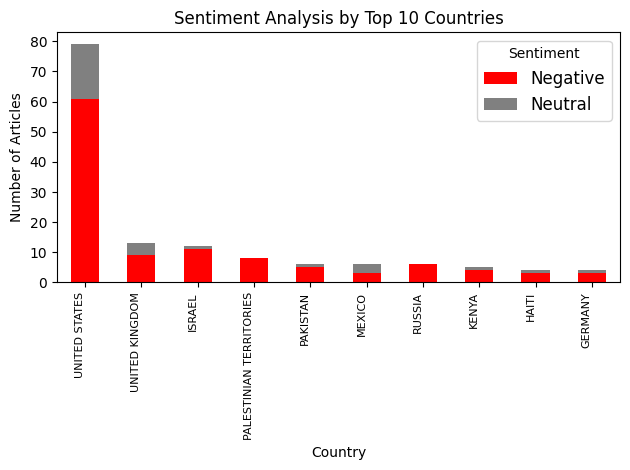

In [16]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# 读取家暴新闻数据
data = pd.read_csv('C:/Users/starfish/Desktop/5507/cleaned_reuters_data_8.csv', encoding='latin1')

# 初始化情感分析器
analyzer = SentimentIntensityAnalyzer()

# 定义情感分析函数
def get_sentiment_score(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)['compound']
    else:
        return None

# 添加情感分析结果列
data['sentiment_score'] = data['content'].apply(get_sentiment_score)
data['sentiment_label'] = data['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

# 提取国家信息
def extract_country(location):
    if isinstance(location, str):
        parts = location.split(',')
        country = parts[-1].strip() if parts else None
        return country if country else 'UNKNOWN'
    return 'UNKNOWN'

# 添加国家列，处理 None 值
data['Country'] = data.apply(lambda row: extract_country(row['location']).upper() if row['location'] else 'UNKNOWN', axis=1)

# 汇总情感分析结果
sentiment_by_country = data[data['Country'] != 'UNKNOWN'].groupby(['Country', 'sentiment_label']).size().unstack(fill_value=0)

# 选择新闻数量前10的国家
top_10_countries = sentiment_by_country.sum(axis=1).sort_values(ascending=False).head(10).index

# 生成图表
plt.figure(figsize=(18, 8))
sentiment_by_country.loc[top_10_countries].plot(kind='bar', stacked=True, color=['red', 'grey', 'green'])
plt.title('Sentiment Analysis by Top 10 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'], fontsize=12)
plt.tight_layout()

# 保存图表
plt.savefig('sentiment_analysis_by_top_10_countries.png')
plt.show()

<Figure size 1200x800 with 0 Axes>

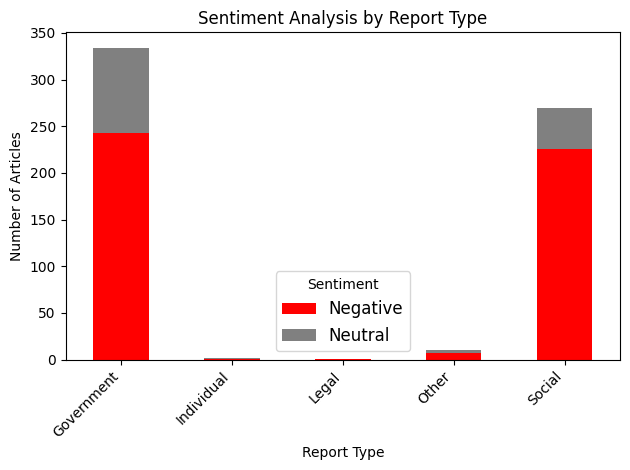

In [17]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
data = pd.read_csv('C:/Users/starfish/Desktop/5507/cleaned_reuters_data_8.csv', encoding='latin1')

# 初始化情感分析器
analyzer = SentimentIntensityAnalyzer()

# 定义情感分析函数
def get_sentiment_score(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)['compound']
    else:
        return None

# 添加情感分析结果列
data['sentiment_score'] = data['content'].apply(get_sentiment_score)
data['sentiment_label'] = data['sentiment_score'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

# 提取报道类型
def extract_report_type(content):
    if isinstance(content, str):  # 确保 content 是字符串
        content_lower = content.lower()
        if 'government' in content_lower or 'policy' in content_lower:
            return 'Government'
        elif 'social' in content_lower or 'aid' in content_lower:
            return 'Social'
        elif 'personal' in content_lower or 'individual' in content_lower:
            return 'Individual'
        elif 'law' in content_lower or 'legal' in content_lower:
            return 'Legal'
        else:
            return 'Other'
    return 'Other'  # 对于非字符串类型返回 'Other'

data['Report_Type'] = data['content'].apply(extract_report_type)

# 汇总情感分析结果按报道类型
sentiment_by_report_type = data.groupby(['Report_Type', 'sentiment_label']).size().unstack(fill_value=0)

# 生成图表
plt.figure(figsize=(12, 8))
sentiment_by_report_type.plot(kind='bar', stacked=True, color=['red', 'grey', 'green'])
plt.title('Sentiment Analysis by Report Type')
plt.xlabel('Report Type')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'], fontsize=12)
plt.tight_layout()
plt.savefig('sentiment_analysis_by_report_type.png')
plt.show()


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


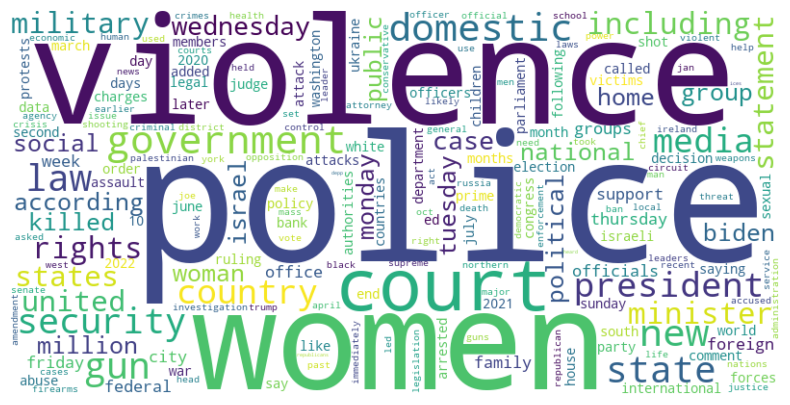

In [18]:
!pip install wordcloud

!pip install scikit-learn

import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


# 假设你的CSV文件路径为 "news_data.csv"
df = pd.read_csv('C:/Users/starfish/Desktop/5507/cleaned_reuters_data_8.csv', encoding='ISO-8859-1')

import pandas as pd

# 确保 'content' 列中的值是字符串类型，如果是 NaN 则替换为空字符串
df['content'] = df['content'].fillna('').astype(str)



# 进行数据预处理：清理文本内容
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # 去除HTML标签
    text = re.sub(r'[^\w\s]', '', text)  # 去除特殊字符
    text = text.strip()  # 去除多余的空格
    text = text.replace("said", "") # 替换 "said" 为 ""
    text = text.replace("told","") #替换"told" 为 ""
    text = text.replace("people", "") # 替换 "people" 为 ""
    text = text.replace("reuters","") #替换"reuters" 为 ""
    text = text.replace("years","") #替换"years" 为 ""
    text = text.replace("year","") #替换"year" 为 ""
    text = text.replace("did","") #替换"did" 为 ""
    text = text.replace("report","") #替换"report" 为 ""
    text = text.replace("time","") #替换"time" 为 ""
    text = text.replace("just","") #替换"just" 为 ""
    return text



# 处理新闻内容并清理
df['content_clean'] = df['content'].apply(clean_text)

# TF-IDF分析
vectorizer = TfidfVectorizer(max_features=200, stop_words='english')
X = vectorizer.fit_transform(df['content_clean'])
tfidf_scores = np.array(X.sum(axis=0)).flatten()  # 获取每个词的TF-IDF值

# 获取关键词
features = vectorizer.get_feature_names_out()

# 创建词频字典并生成词云
word_freq = dict(zip(features, tfidf_scores))

if 'reuters' in word_freq:
    del word_freq['reuters']
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# 可视化词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
import nltk

# 下载 NLTK 所需的资源
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import nltk
print(nltk.data.path)

['C:\\Users\\starfish/nltk_data', 'c:\\dev\\python\\nltk_data', 'c:\\dev\\python\\share\\nltk_data', 'c:\\dev\\python\\lib\\nltk_data', 'C:\\Users\\starfish\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\starfish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\starfish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\starfish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# 导入必要的库
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

# 下载 NLTK 所需的资源（如果尚未下载）
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 读取数据
data = pd.read_csv('C:/Users/starfish/Desktop/5507/cleaned_reuters_data_8.csv', encoding='latin1')

# 假设数据集中有一列叫 'Content'，其中包含新闻文本
documents = data['content'].dropna().tolist()

# 文本预处理函数
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # 小写化并分词
    tokens = word_tokenize(text.lower())
    # 去除停用词和非字母字符
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    
    return tokens

# 处理数据集
processed_docs = [preprocess(doc) for doc in documents]

# 创建字典
dictionary = corpora.Dictionary(processed_docs)

# 将文档转换为 Bag of Words 格式
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# 设置主题数量
num_topics = 5  # 可以根据需要调整主题数量

# 训练 LDA 模型
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

# 打印主题
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"Topic {idx + 1}: {topic}")

# 准备 LDA 模型进行可视化
lda_visualization = gensimvis.prepare(lda_model, corpus, dictionary)

# 显示可视化
pyLDAvis.display(lda_visualization)

# 可选：保存可视化为 HTML 文件
pyLDAvis.save_html(lda_visualization, 'lda_visualization.html')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\starfish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\starfish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\starfish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Topic 1: 0.018*"said" + 0.006*"people" + 0.005*"u" + 0.005*"year" + 0.004*"violence"
Topic 2: 0.021*"said" + 0.006*"violence" + 0.005*"israel" + 0.005*"would" + 0.005*"reuters"
Topic 3: 0.016*"gun" + 0.012*"court" + 0.012*"said" + 0.010*"u" + 0.009*"law"
Topic 4: 0.016*"said" + 0.011*"police" + 0.007*"violence" + 0.006*"domestic" + 0.006*"officer"
Topic 5: 0.018*"said" + 0.006*"state" + 0.006*"violence" + 0.005*"reuters" + 0.005*"u"


In [20]:
# 准备 LDA 模型进行可视化
lda_visualization = gensimvis.prepare(lda_model, corpus, dictionary)

# 直接在 Jupyter Notebook 中显示可视化结果
pyLDAvis.display(lda_visualization)